In [100]:
import pandas as pd

In [101]:
df = pd.read_parquet('/Users/tanishqagarwal/Downloads/data.parquet') 

In [102]:
import pyarrow.parquet as pq

# Load the Parquet file
parquet_file = '/Users/tanishqagarwal/Downloads/data.parquet'
table = pq.read_table(parquet_file)

# Convert the table to a Pandas DataFrame
df = table.to_pandas()

# Display the DataFrame
print(df.head())

                     banknifty     nifty  tte
time                                         
2021-01-01 09:15:00   0.286058  0.199729   27
2021-01-01 09:16:00   0.285381  0.200433   27
2021-01-01 09:17:00   0.284233  0.200004   27
2021-01-01 09:18:00   0.286104  0.199860   27
2021-01-01 09:19:00   0.285539  0.198951   27


In [103]:
# Calculate the spread
df['spread'] = df['banknifty'] - df['nifty']

In [104]:
def calculate_zscore(series, window_size):
    mean = series.rolling(window=window_size).mean()
    std = series.rolling(window=window_size).std()
    zscore = (series - mean) / std
    return zscore

In [105]:
# Define the rolling window size (adjust as needed)
window_size = 30
df['zscore'] = calculate_zscore(df['spread'], window_size)

In [106]:
# Define the z-score threshold for entering and exiting positions
entry_threshold = 1.0
exit_threshold = 0.0

# Generate trading signals
df['long_signal'] = df['zscore'] < -entry_threshold
df['short_signal'] = df['zscore'] > entry_threshold
df['exit_signal'] = (df['zscore'].abs() < exit_threshold) & (df['zscore'].shift(1).abs() >= exit_threshold)


In [107]:
# Define the position size
position_size = 1

# Calculate daily P/L
df['daily_pl'] = position_size * df['spread'] * df['exit_signal'].shift(-1)

# Calculate cumulative P/L
df['cumulative_pl'] = df['daily_pl'].cumsum()


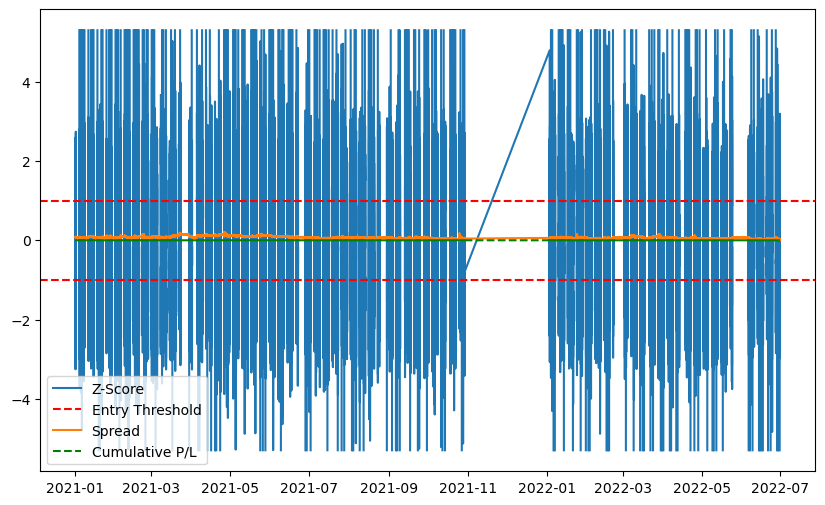

In [108]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['zscore'], label='Z-Score')
plt.axhline(entry_threshold, color='r', linestyle='--', label='Entry Threshold')
plt.axhline(-entry_threshold, color='r', linestyle='--')
plt.plot(df['spread'], label='Spread')
plt.plot(df['cumulative_pl'], label='Cumulative P/L', linestyle='--', color='g')
plt.legend()
plt.show()


In [109]:
# Forward fill missing values
df = df.ffill()


In [110]:
# Recalculate the 'spread' column
df['spread'] = df['banknifty'] - df['nifty']

In [111]:
# Check for NaN values in relevant columns
print(df[['spread', 'tte', 'daily_pl']].isnull().sum())


spread      0
tte         0
daily_pl    0
dtype: int64


Total P/L: 0.00
Sharpe Ratio: 2713839909788.2368
Max Drawdown: 0.00


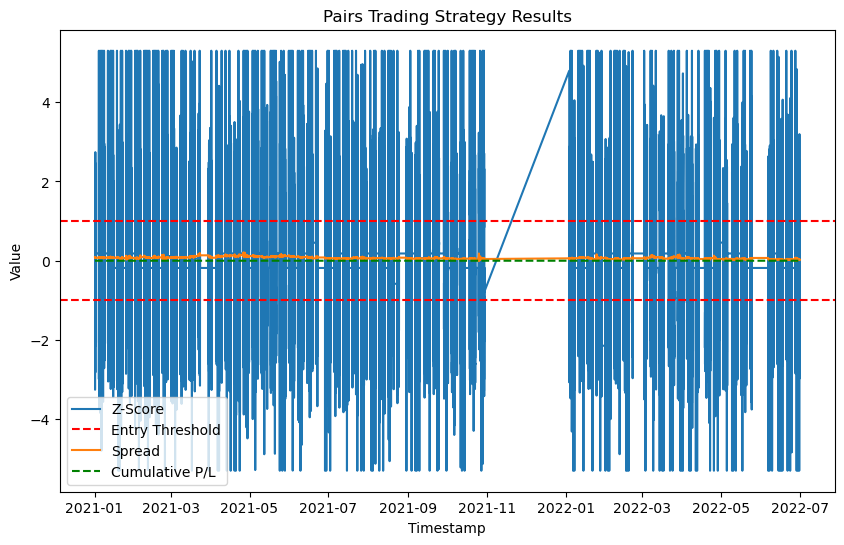

In [112]:
import matplotlib.pyplot as plt

# Analyze Results

import numpy as np

# Calculate performance metrics
total_pl = df['cumulative_pl'].iloc[-1]

# Check for missing values and replace them with 0
df['daily_pl'] = df['daily_pl'].fillna(0)

# Avoid division by zero and replace infinite values
df['daily_pl'] = df['daily_pl'].replace(0, 1e-10)
df['daily_pl'] = np.where(np.isinf(df['daily_pl']), np.nan, df['daily_pl'])

sharpe_ratio = df['daily_pl'].mean() / df['daily_pl'].std() * (252**0.5)  # Assuming 252 trading days in a year
max_drawdown = (df['cumulative_pl'] - df['cumulative_pl'].cummax()).min()

# Print performance metrics
print(f'Total P/L: {total_pl:.2f}')
print(f'Sharpe Ratio: {sharpe_ratio:.4f}')
print(f'Max Drawdown: {max_drawdown:.2f}')

# Visualize results
plt.figure(figsize=(10, 6))
plt.plot(df['zscore'], label='Z-Score')
plt.axhline(entry_threshold, color='r', linestyle='--', label='Entry Threshold')
plt.axhline(-entry_threshold, color='r', linestyle='--')
plt.plot(df['spread'], label='Spread')
plt.plot(df['cumulative_pl'], label='Cumulative P/L', linestyle='--', color='g')
plt.legend()
plt.title('Pairs Trading Strategy Results')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.show()


# Building a Linear Regression Model

In [113]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assume 'features' is a DataFrame containing relevant features for your model
features = df[['banknifty', 'nifty', 'tte']]

# Create target variable (P/L) based on the provided formula
df['pl_target'] = df['spread'] * (df['tte'] ** 0.7)

# Split data into training and testing sets
train_size = int(0.8 * len(df))
train_data, test_data = df[:train_size], df[train_size:]

# Fit a linear regression model
model = LinearRegression()
model.fit(train_data[['banknifty', 'nifty', 'tte']], train_data['pl_target'])

# Make predictions on the test set
test_data['pl_pred'] = model.predict(test_data[['banknifty', 'nifty', 'tte']])

# Calculate P/L based on the predictions
test_data['daily_pl_model'] = position_size * test_data['pl_pred'] * test_data['exit_signal'].shift(-1)

# Calculate cumulative P/L for the model
test_data['cumulative_pl_model'] = test_data['daily_pl_model'].cumsum()

# Display the performance metrics for the model
total_pl_model = test_data['cumulative_pl_model'].iloc[-1]
sharpe_ratio_model = test_data['daily_pl_model'].mean() / test_data['daily_pl_model'].std() * (252**0.5)
max_drawdown_model = (test_data['cumulative_pl_model'] - test_data['cumulative_pl_model'].cummax()).min()

print(f'Total P/L Model: {total_pl_model:.2f}')
print(f'Sharpe Ratio Model: {sharpe_ratio_model:.4f}')
print(f'Max Drawdown Model: {max_drawdown_model:.2f}')


Total P/L Model: nan
Sharpe Ratio Model: nan
Max Drawdown Model: 0.00


/var/folders/n6/dc562gvj2_z2ymq85xcckjsr0000gn/T/ipykernel_61504/1669108146.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['pl_pred'] = model.predict(test_data[['banknifty', 'nifty', 'tte']])
/var/folders/n6/dc562gvj2_z2ymq85xcckjsr0000gn/T/ipykernel_61504/1669108146.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['daily_pl_model'] = position_size * test_data['pl_pred'] * test_data['exit_signal'].shift(-1)
/var/folders/n6/dc562gvj2_z2ymq85xcckjsr0000gn/T/ipykernel_61504/166910

In [114]:
print(test_data[['pl_pred', 'exit_signal']].head())

                      pl_pred  exit_signal
time                                      
2022-03-26 17:48:00  0.342925        False
2022-03-26 17:49:00  0.342925        False
2022-03-26 17:50:00  0.342925        False
2022-03-26 17:51:00  0.342925        False
2022-03-26 17:52:00  0.342925        False


In [115]:
print("Model Coefficients:", model.coef_)

Model Coefficients: [ 5.97915817 -5.96077553  0.02491166]


In [116]:
# Check if features are constant
constant_features = df[['banknifty', 'nifty', 'tte']].nunique()
print("Constant Features:", constant_features)

# Print model coefficients
print("Model Coefficients:", model.coef_)

Constant Features: banknifty    100252
nifty         97492
tte              22
dtype: int64
Model Coefficients: [ 5.97915817 -5.96077553  0.02491166]


In [117]:
print(test_data[['banknifty', 'nifty', 'tte', 'exit_signal']].head())

                     banknifty     nifty  tte  exit_signal
time                                                      
2022-03-26 17:48:00   0.285112  0.194459    6        False
2022-03-26 17:49:00   0.285112  0.194459    6        False
2022-03-26 17:50:00   0.285112  0.194459    6        False
2022-03-26 17:51:00   0.285112  0.194459    6        False
2022-03-26 17:52:00   0.285112  0.194459    6        False


In [118]:
import pandas as pd

# Load data from the Parquet file
file_path = '/Users/tanishqagarwal/Downloads/data.parquet'  # Replace with the actual path to your data file
df = pd.read_parquet(file_path)

# Extract 'banknifty' and 'nifty' columns
banknifty = df['banknifty']
nifty = df['nifty']

# Display a few rows of the extracted data
print("Bank Nifty:")
print(banknifty.head())

print("\nNifty:")
print(nifty.head())


Bank Nifty:
time
2021-01-01 09:15:00    0.286058
2021-01-01 09:16:00    0.285381
2021-01-01 09:17:00    0.284233
2021-01-01 09:18:00    0.286104
2021-01-01 09:19:00    0.285539
Name: banknifty, dtype: float64

Nifty:
time
2021-01-01 09:15:00    0.199729
2021-01-01 09:16:00    0.200433
2021-01-01 09:17:00    0.200004
2021-01-01 09:18:00    0.199860
2021-01-01 09:19:00    0.198951
Name: nifty, dtype: float64


In [119]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.impute import SimpleImputer
# Load data from the Parquet file
file_path = '/Users/tanishqagarwal/Downloads/data.parquet'  # Replace with the actual path to your data file
df = pd.read_parquet(file_path)

# Assuming 'target_variable' is the variable you want to predict
target_variable = 'tte'  # Replace with your actual target variable name

# Features: 'banknifty' and 'nifty'
features = ['banknifty', 'nifty']

# Extract features and target variable
X = df[features]
y = df[target_variable]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Replace NaN values with the mean of each column
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Build a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display model coefficients and performance metrics
print("Model Coefficients:", model.coef_)
print("Mean Squared Error:", mse)
print("R-squared:", r2)


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# Comparison

In [ ]:
# Compare the z-score model with the linear regression model
plt.figure(figsize=(12, 8))
plt.plot(df['cumulative_pl'], label='Z-Score Model', linestyle='--')
plt.plot(test_data['cumulative_pl_model'], label='Linear Regression Model', linestyle='--')
plt.legend()
plt.title('Comparison of Trading Models')
plt.xlabel('Timestamp')
plt.ylabel('Cumulative P/L')
plt.show()

KeyError: 'cumulative_pl'

<Figure size 1200x800 with 0 Axes>